In [1]:
import os
import sys
import glob

sys.path.append(os.getcwd())

import torch
from lossless.component.coolchic import CoolChicEncoderParameter
from lossless.component.frame import load_frame_encoder
from lossless.component.types import NAME_COOLCHIC_ENC
from lossless.component.image import (
    FrameEncoderManager,
    encode_one_frame,
)
from enc.utils.codingstructure import CodingStructure, Frame
from typing import Any, Dict, List
from lossless.component.coolchic import CoolChicEncoder
from torchac import torchac
import numpy as np
import cv2
import matplotlib.pyplot as plt

from lossless.util.config import (
    DATASET_PATH,
    TEST_WORKDIR,
    PATH_COOL_CHIC_CFG,
    IMAGE_PATHS,
    args,
    start_print
)
from lossless.util.print_formatting import pretty_str_dict
from lossless.util.parsecli import change_n_out_synth, get_coolchic_param_from_args, get_manager_from_args
from lossless.util.misc import clean_workdir
from lossless.training.train import train

print(IMAGE_PATHS)
print(pretty_str_dict(args))
print("----------")
print(start_print)

frame_encoder_manager = FrameEncoderManager(**get_manager_from_args(args))

Using /home/jakub/.cache/torch_extensions/py310_cu126 as PyTorch extensions root...
Emitting ninja build file /home/jakub/.cache/torch_extensions/py310_cu126/torchac_backend/build.ninja...
Building extension module torchac_backend...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module torchac_backend...


ninja: no work to do.
['/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim01.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim02.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim03.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim04.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim05.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim06.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim07.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim08.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim09.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim10.png', '/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/k

In [2]:
clean_workdir(args["workdir"])

Removing /home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/test-workdir/...


/home/jakub/ETH/2025_2026_fall/thesis/Cool-Chic/coolchic/../datasets/kodak/kodim01.png


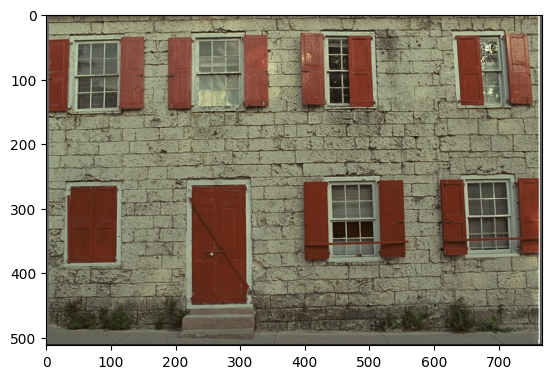

torch.Size([1, 3, 512, 768])


In [3]:
print(args["input"])
im = cv2.imread(filename=args["input"])
assert im is not None, f"Failed to read image {args['input']}"
im = im[:, :, ::-1]  # Convert BGR to RGB
plt.imshow(im)
plt.show()

im = im.transpose(2, 0, 1)[None,]  # Change to CxHxW
im_tensor = torch.from_numpy(im.copy()).float() / 255.0  # Normalize to [0, 1]
print(im_tensor.shape)
im_tensor = im_tensor.to("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
encoder_param = CoolChicEncoderParameter(
    **get_coolchic_param_from_args(args, "residue")
)
encoder_param.set_image_size((512, 768))
encoder_param.layers_synthesis = change_n_out_synth(
    encoder_param.layers_synthesis, 6
)

coolchic = CoolChicEncoder(param=encoder_param)
coolchic.to_device("cuda:0")
# coolchic.eval()

# for i, grid in enumerate(coolchic.latent_grids):
#     # Instead of default initialization, use larger values
#     grid.data.normal_(0.2, 0.5)  # Mean=0, std=0.5 instead of very small values
#     print(f"   Reinitialized Grid {i}: mean={grid.data.mean():.4f}, std={grid.data.std():.4f}")

# print(coolchic.pretty_string(True))


In [5]:
frame_encoder = train(
    model=coolchic,
    target_image=im_tensor,
    frame_encoder_manager=frame_encoder_manager,
    start_lr=args["start_lr"],
    lmbda=args["lmbda"],
    cosine_scheduling_lr=args["schedule_lr"],
    max_iterations=args["n_itr"],
    frequency_validation=args["freq_valid"],
    patience=args["patience"],
    optimized_module=args["optimized_module"],
    quantizer_type=args["quantizer_type"],
    quantizer_noise_type=args["quantizer_noise_type"],
    softround_temperature=args["softround_temperature"],
    noise_parameter=args["noise_parameter"],
)

Loss: 8.2668, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2668
Loss: 8.2576, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2576
Loss: 8.2486, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2486
Loss: 8.2467, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2467
Loss: 8.2432, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2432
Loss: 8.2425, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2425
Loss: 8.2422, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2422
Loss: 8.2421, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2421
Loss: 8.2421, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2421
Loss: 8.2421, Rate NN: 0.0000, Rate Latent: 0.0000, Rate Img: 8.2421


In [6]:
with torch.no_grad():
    # Forward pass with no quantization noise
    # This is a random prior, i.e. the output is not conditioned on any input
    # image.
    random_prior = coolchic.forward(
        img_tensor=im_tensor,
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=-1,
        flag_additional_outputs=False,
    )
print(f"Random prior: {random_prior.keys()}")

Random prior: dict_keys(['raw_out', 'rate', 'img_bpd', 'latent_bpd', 'additional_data'])


torch.Size([1, 6, 512, 768])
torch.Size([524256])
tensor(-6.8627, device='cuda:0') tensor(14.3783, device='cuda:0')


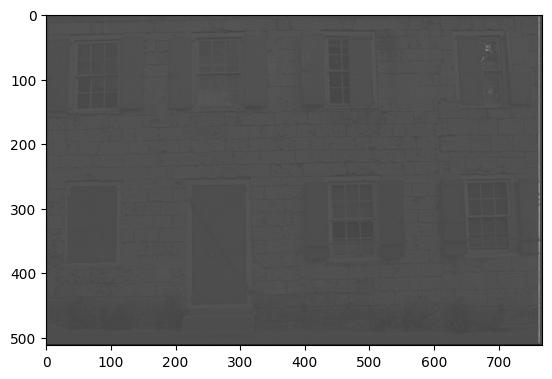

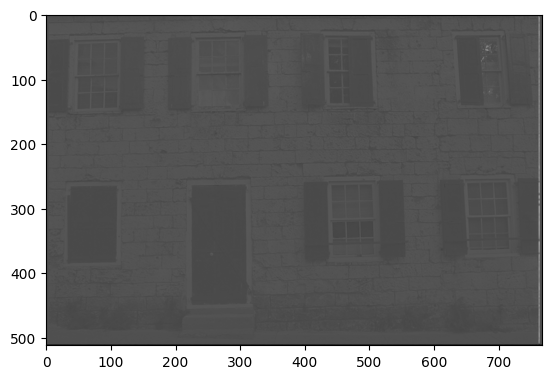

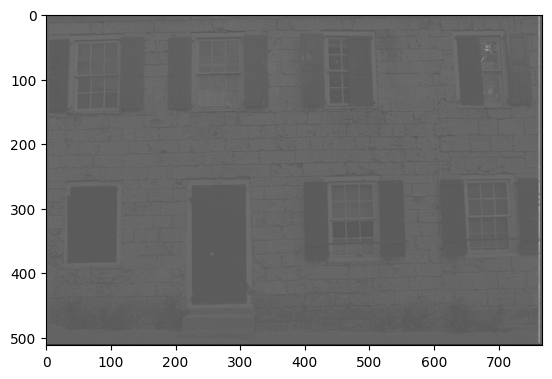

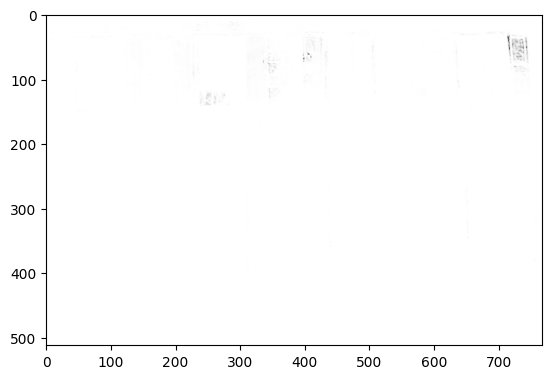

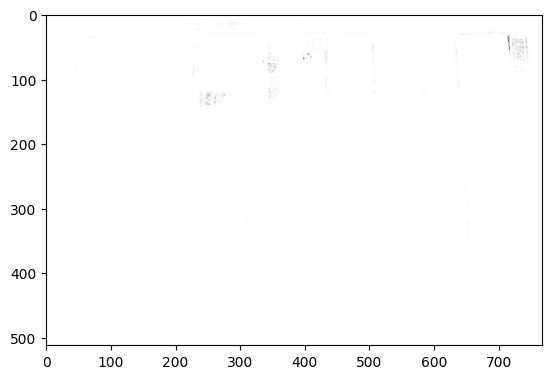

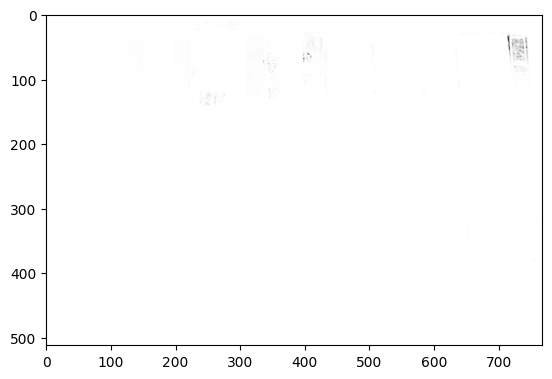

In [7]:
# 
print(random_prior["raw_out"].size())
print(random_prior["rate"].size())
# print(random_prior["additional_data"])
print(torch.min(random_prior["raw_out"]), torch.max(random_prior["raw_out"]))

for slice_index in range(6):
    image_tensor_2d = random_prior["raw_out"].cpu().numpy()[0, slice_index]
    plt.imshow(
        image_tensor_2d,
        cmap="gray",
    )
    plt.show()
plt.show()

In [8]:
rans_freq_precision: int = 16


def modify_regular_prob(probs: torch.Tensor) -> torch.Tensor:
    """
    function to modify the frequencies of the symbols that all possible value has at lease 1 frequency and the sum of the frequencies is 2**rans_freq_precision
    """
    a = 2 ** (-rans_freq_precision)
    n = 256
    probs = probs * (1 - n * a) + a
    return probs


def compute_logistic_cdfs(
    mu: torch.Tensor, scale: torch.Tensor, bitdepth: int
) -> torch.Tensor:
    """
    function to calculate the cdfs of the Logistic(mu, scale) distribution
    used for encoder
    """
    mu = mu
    scale = scale
    n, c, h, w = mu.shape
    max_v = float((1 << bitdepth) - 1)
    size = 1 << bitdepth
    interval = 1.0 / max_v
    endpoints = torch.arange(
        -1.0 + interval, 1.0, 2 * interval, device=mu.device
    ).repeat(
        (n, c, h, w, 1)
    )  # n c w h maxv
    mu = mu.unsqueeze(-1).repeat((1, 1, 1, 1, size - 1))  # n c w h maxv
    scale = scale.unsqueeze(-1).repeat((1, 1, 1, 1, size - 1))  # n c w h maxv
    invscale = 1.0 / scale
    endpoints_rescaled = (endpoints - mu) * invscale
    cdfs = torch.zeros(n, c, h, w, size + 1, device=mu.device)
    cdfs[..., 1:-1] = torch.sigmoid(endpoints_rescaled)
    cdfs[..., -1] = 1.0
    probs = cdfs[..., 1:] - cdfs[..., :-1]
    probs = modify_regular_prob(probs)
    torch.use_deterministic_algorithms(False)
    cdfs[..., 1:] = torch.cumsum(probs, dim=-1)
    torch.use_deterministic_algorithms(True)
    cdfs[..., -1] = 1.0
    cdfs_q = torch.round(cdfs * float(1 << rans_freq_precision)).to(torch.int16)
    return cdfs_q


def encode(x: torch.Tensor, mu: torch.Tensor, scale: torch.Tensor):
    x_maxv = (1 << 8) - 1
    x = torch.round(x_maxv * x).to(torch.int16).float() / x_maxv
    x_reshape = torch.round(x * ((1 << 8) - 1)).to(torch.int16).cpu()

    byte_strings = []
    for i in range(3):
        symbols = x_reshape[:, i : i + 1, ...]
        print(
            f"Channel {i}: symbols shape {symbols.shape}, min {symbols.min()}, max {symbols.max()}"
        )
        cur_cdfs = compute_logistic_cdfs(
            mu[:, i : i + 1, ...], scale[:, i : i + 1, ...], 8
        ).cpu()
        byte_strings.append(
            torchac.encode_int16_normalized_cdf(cur_cdfs, symbols)
        )
    return byte_strings


def decode(byte_strings: list, mu: torch.Tensor, scale: torch.Tensor):
    assert len(byte_strings) == 3
    x_maxv = (1 << 8) - 1

    _, _, h, w = mu.size()
    x_rec = torch.zeros(1, 3, h, w)

    # Channel 0 (Red)
    cur_cdfs_r = compute_logistic_cdfs(
        mu[:, :1, ...], scale[:, :1, ...], 8
    ).cpu()
    symbols_r = torchac.decode_int16_normalized_cdf(cur_cdfs_r, byte_strings[0])
    print(
        f"Decoded R: shape {symbols_r.shape}, min {symbols_r.min()}, max {symbols_r.max()}"
    )
    x_r = symbols_r.reshape(1, 1, h, w).float() / x_maxv
    x_rec[:, 0:1, ...] = x_r  # FIX: was using 3*i (which is 0), should be 0:1

    # Channel 1 (Green)
    cur_cdfs_g = compute_logistic_cdfs(
        mu[:, 1:2, ...], scale[:, 1:2, ...], 8
    ).cpu()
    symbols_g = torchac.decode_int16_normalized_cdf(cur_cdfs_g, byte_strings[1])
    print(
        f"Decoded G: shape {symbols_g.shape}, min {symbols_g.min()}, max {symbols_g.max()}"
    )
    x_g = symbols_g.reshape(1, 1, h, w).float() / x_maxv
    x_rec[:, 1:2, ...] = x_g  # FIX: was using 3*i+1 (which is 1), should be 1:2

    # Channel 2 (Blue)
    cur_cdfs_b = compute_logistic_cdfs(
        mu[:, 2:3, ...], scale[:, 2:3, ...], 8
    ).cpu()
    symbols_b = torchac.decode_int16_normalized_cdf(cur_cdfs_b, byte_strings[2])
    print(
        f"Decoded B: shape {symbols_b.shape}, min {symbols_b.min()}, max {symbols_b.max()}"
    )
    x_b = symbols_b.reshape(1, 1, h, w).float() / x_maxv
    x_rec[:, 2:3, ...] = x_b  # FIX: was using 3*i+2 (which is 2), should be 2:3

    return x_rec


def get_scale(logscale: torch.Tensor) -> torch.Tensor:
    """
    function to calculate the scale from the log-scale
    """
    return torch.exp(-0.5 * torch.clamp(logscale, min=-10.0, max=13.8155))


def get_mu_scale(params: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """
    function to calculate the mean and scale from the parameters
    """
    mu, logscale = torch.chunk(params, 2, dim=1)
    scale = get_scale(logscale)
    return mu, scale


def laplace_cdf(
    x: torch.Tensor, loc: torch.Tensor, scale: torch.Tensor
) -> torch.Tensor:
    """Compute the laplace cumulative evaluated in x. All parameters
    must have the same dimension.

    Args:
        x (Tensor): Where the cumulative if evaluated.
        loc (Tensor): Expectation.
        scale (Tensor): Scale

    Returns:
        Tensor: CDF(x, mu, scale)
    """
    return 0.5 - 0.5 * (x - loc).sign() * torch.expm1(-(x - loc).abs() / scale)


def get_latent_rate(
    x: torch.Tensor, params: torch.Tensor, bitdepth: int, freq_precision: int
) -> torch.Tensor:
    """Compute the laplace log-probability evaluated in x. All parameters
    must have the same dimension.

    Args:
        x (Tensor): Where the log-probability if evaluated.
        loc (Tensor): Expectation.
        scale (Tensor): Scale

    Returns:
        Tensor: log(P(x | mu, scale))
    """
    n = 1 << bitdepth
    mu, scale = get_mu_scale(params)
    prob = laplace_cdf(x + 0.5, mu, scale) - laplace_cdf(x - 0.5, mu, scale)
    a = float(2 ** (-freq_precision))
    prob = (1 - n * a) * prob + a
    logp = torch.log2(prob)
    return -logp

In [28]:
mu = random_prior["raw_out"][:, :3]
scale = random_prior["raw_out"][:, 3:6]
clamp_scale_to = 0.00919
scale = torch.clamp(scale,min = clamp_scale_to, max=clamp_scale_to)
mu = torch.clamp(mu,min = -1, max=1)
print(f"mu: {mu.min()} {mu.max()}, scale: {scale.min()} {scale.max()}")
encoded_bytes = encode(im_tensor, mu, scale)

mu: -1.0 1.0, scale: 0.009189999662339687 0.009189999662339687
Channel 0: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
Channel 1: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255
Channel 2: symbols shape torch.Size([1, 1, 512, 768]), min 0, max 255


In [29]:
def get_bits_per_pixel(w, h, c, encoded_bytes):
    num_pixels = w * h * c
    num_bits = 0
    for bytes_channel in encoded_bytes:
        num_bits += len(bytes_channel) * 8
    return num_bits / num_pixels

print(get_bits_per_pixel(768, 512, 3, encoded_bytes))

4.819315592447917


In [30]:
best_bpd = 4.103868272569445
if get_bits_per_pixel(768, 512, 3, encoded_bytes) < best_bpd:
    best_bpd = get_bits_per_pixel(768, 512, 3, encoded_bytes)
    print(f"Best BPD: {best_bpd}")

In [31]:
print(encoded_bytes[0][:10])

b'\xbc\xe8\x16\xb7a<\x14f_i'


Decoded R: shape torch.Size([1, 1, 512, 768]), min 0, max 255
Decoded G: shape torch.Size([1, 1, 512, 768]), min 0, max 255
Decoded B: shape torch.Size([1, 1, 512, 768]), min 0, max 255
0.0 1.0


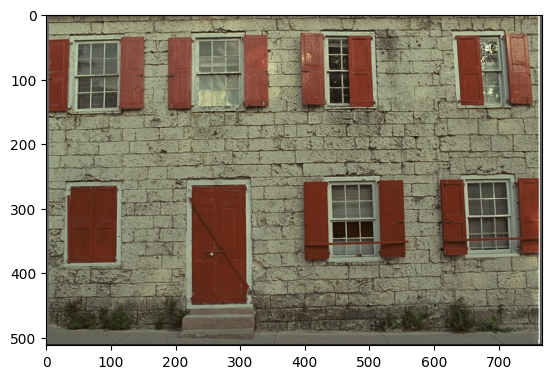

PNG bpd: 4.995 vs New lossless method: 4.819


In [32]:

decoded_im = decode(encoded_bytes, mu, scale)
decoded_im = decoded_im.cpu().numpy()
print(np.min(decoded_im), np.max(decoded_im))

# decoded_im has shape torch.Size([1, 3, 512, 768])
# show it via plt

# decoded_im is a numpy array with shape (1, 3, 512, 768)
# To display as an image, we need shape (512, 768, 3)
plt.imshow(np.transpose(decoded_im[0], (1, 2, 0)))
plt.show()
assert np.allclose(decoded_im, im_tensor.cpu().numpy()), "Decoded image does not match original"
print(f"PNG bpd: {736501 / 768 / 512 / 3 * 8:.3f} vs New lossless method: {get_bits_per_pixel(768, 512, 3, encoded_bytes):.3f}")

In [33]:
# Let's verify the fix worked by checking reconstruction
print("🔍 VERIFYING LOSSLESS RECONSTRUCTION:")
print("-" * 40)

print(f"Original image shape: {im_tensor.shape}")
print(f"Original image range: [{im_tensor.min():.6f}, {im_tensor.max():.6f}]")

print(f"\nDecoded image shape: {decoded_im.shape}")
print(f"Decoded image range: [{decoded_im.min():.6f}, {decoded_im.max():.6f}]")

# Check if reconstruction is perfect (lossless)
reconstruction_error = np.abs(im_tensor.cpu().numpy() - decoded_im).max()
print(f"\nMax reconstruction error: {reconstruction_error:.10f}")

if reconstruction_error < 1e-6:
    print("✅ SUCCESS: Perfect lossless reconstruction!")
else:
    print(f"❌ ISSUE: Reconstruction error = {reconstruction_error}")
    
    # Let's check per channel
    for i in range(3):
        channel_error = np.abs(im_tensor[0, i].cpu().numpy() - decoded_im[0, i]).max()
        print(f"   Channel {i} error: {channel_error:.10f}")

# Check some statistics
print(f"\nChannel statistics:")
for i in range(3):
    orig_mean = im_tensor[0, i].mean().item()
    decoded_mean = decoded_im[0, i].mean()
    print(f"   Channel {i}: Original mean={orig_mean:.6f}, Decoded mean={decoded_mean:.6f}")

🔍 VERIFYING LOSSLESS RECONSTRUCTION:
----------------------------------------
Original image shape: torch.Size([1, 3, 512, 768])
Original image range: [0.000000, 1.000000]

Decoded image shape: (1, 3, 512, 768)
Decoded image range: [0.000000, 1.000000]

Max reconstruction error: 0.0000000000
✅ SUCCESS: Perfect lossless reconstruction!

Channel statistics:
   Channel 0: Original mean=0.469652, Decoded mean=0.469652
   Channel 1: Original mean=0.426456, Decoded mean=0.426456
   Channel 2: Original mean=0.346614, Decoded mean=0.346614
